# 1. Using itk-elastix: A first registration

In this notebook we'll learn the basics of how to register and transform images using `itk-elastix`.

As example data, we'll use two channels of a fluorescent image.

Also check the [elastix manual](https://elastix.lumc.nl/download/elastix-5.0.1-manual.pdf).

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading the data

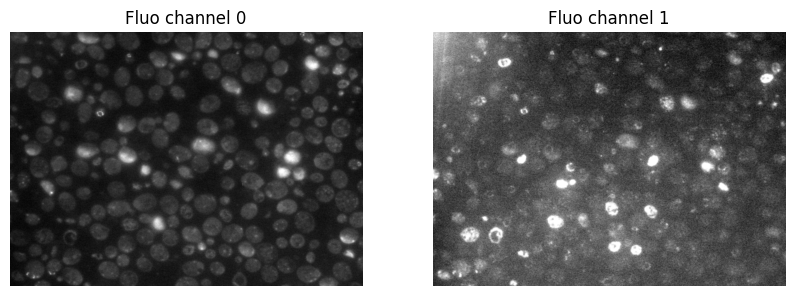

In [2]:
from skimage import io

im1 = io.imread("../example_data/fluo_ch0.tif")
im2 = io.imread("../example_data/fluo_ch1.tif")

# show the images next to each other
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(im1, cmap='gray')
ax[0].set_title('Fluo channel 0')
ax[0].axis('off')
ax[1].imshow(im2, cmap='gray')
ax[1].set_title('Fluo channel 1')
ax[1].axis('off')

plt.show()

## Registration

### Defining fixed and moving image

Image registration typically works with a fixed and a moving image. The goal is to find the spatial transformation that makes the moving image align with the fixed image.

How to choose which image is fixed and which is moving? The fixed image is the one used as a reference, while the moving image is typically transformed to align with the fixed image.

In [3]:
fixed_image = im1
moving_image = im2

### Defining image properties

In the context of image registration it is important that image are placed into a physical coordinate system. For this purpose, we convert images originally loaded as numpy arrays into itk images. These have two important properties:
- image spacing: the pixel spacing or physical distance between two images
- image origin: a translational offset each images can have with respect to the origin of the coordinate system

If not set, default values of (1, 1) and (0, 0) are assumed.

In [47]:
pixel_spacing = [2, 2]

fixed_image_itk = itk.GetImageFromArray(im1)
moving_image_itk = itk.GetImageFromArray(im2)

# these lines are optional
fixed_image_itk.SetSpacing(tuple([float(v) for v in pixel_spacing])) # needs to be set as tuple of floats
fixed_image_itk.SetOrigin(tuple([float(v) for v in [0, 0]])) # needs to be set as tuple of floats

moving_image_itk.SetSpacing(tuple([float(v) for v in pixel_spacing])) # needs to be set as tuple of floats
moving_image_itk.SetOrigin(tuple([float(v) for v in [0, 0]])) # needs to be set as tuple of floats


### Importing `itk-elastix`

Actually, the elastix functionality (relating to `elastix` and `transformix`) is contained with the Python package named `itk`, which was installed under the name `itk-elastix`.

In [4]:
import itk

### Defining the registration parameters

In command line elastix, the registration parameters are defined in a parameter file. In Python, we can define the parameters in a dictionary.

In [48]:
# we can load the default parameter map for different types of transforms
# here we load the default parameter map for translation transforms
default_translation_parameter_map = itk.ParameterObject.New().GetDefaultParameterMap('translation')

# print the default parameter map
pd.DataFrame(
    {'Parameters': default_translation_parameter_map.keys(),
    'Values': default_translation_parameter_map.values()}
    )

,Parameters,Values
0,AutomaticParameterEstimation,"(true,)"
1,AutomaticTransformInitialization,"(true,)"
2,CheckNumberOfSamples,"(true,)"
3,DefaultPixelValue,"(0,)"
4,FinalBSplineInterpolationOrder,"(3,)"
5,FixedImagePyramid,"(FixedSmoothingImagePyramid,)"
6,ImageSampler,"(RandomCoordinate,)"
7,Interpolator,"(LinearInterpolator,)"
8,MaximumNumberOfIterations,"(256,)"
9,MaximumNumberOfSamplingAttempts,"(8,)"


In [49]:
# we could change a paremeter like in the following example
# notice that all parameter values are tuples of strings

default_translation_parameter_map['MaximumNumberOfIterations'] = ("300", )

# print the default parameter map
pd.DataFrame(
    {'Parameters': default_translation_parameter_map.keys(),
    'Values': default_translation_parameter_map.values()}
    )

,Parameters,Values
0,AutomaticParameterEstimation,"(true,)"
1,AutomaticTransformInitialization,"(true,)"
2,CheckNumberOfSamples,"(true,)"
3,DefaultPixelValue,"(0,)"
4,FinalBSplineInterpolationOrder,"(3,)"
5,FixedImagePyramid,"(FixedSmoothingImagePyramid,)"
6,ImageSampler,"(RandomCoordinate,)"
7,Interpolator,"(LinearInterpolator,)"
8,MaximumNumberOfIterations,"(300,)"
9,MaximumNumberOfSamplingAttempts,"(8,)"


In [50]:
# before running the registration, we need to create a
# registration parameter object to which we add the parameter map we just created
# (we could also add multiple parameter maps)

registration_parameter_object = itk.ParameterObject.New()
registration_parameter_object.AddParameterMap(default_translation_parameter_map)

### Running the registration

In [51]:
transformed_moving_image, result_transform_parameters = itk.elastix_registration_method(
    fixed_image_itk,
    moving_image_itk,
    parameter_object=registration_parameter_object,
    log_to_console=False
    )

## Visual inspection of the registration result

`transformed_moving_image` is an itk image (which is an array + some metadata attached). However, it behaves almost like a numpy arrays.
For converting it into a numpy array, we can call `itk.GetArrayFromImage(transformed_moving_image)`.

### Option 1: Using a checkerboard pattern

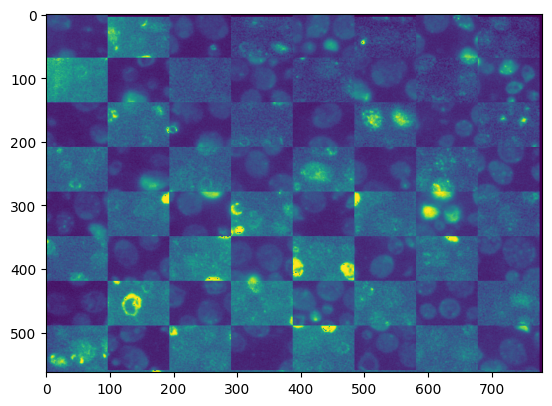

In [57]:
from skimage.util import compare_images

plt.imshow(compare_images(fixed_image_itk, transformed_moving_image, method='checkerboard'))

### Option 2: Use a slider

In [22]:
import jupyter_compare_view

Jupyter compare_view v0.2.4



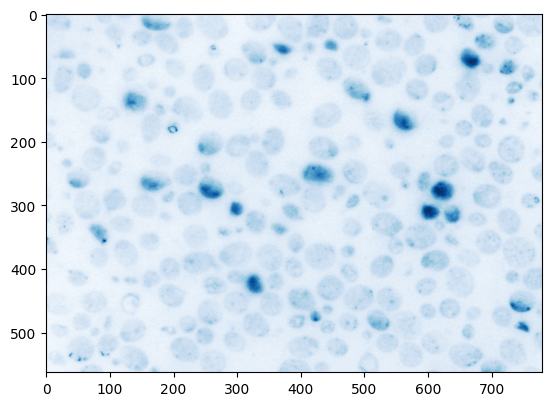
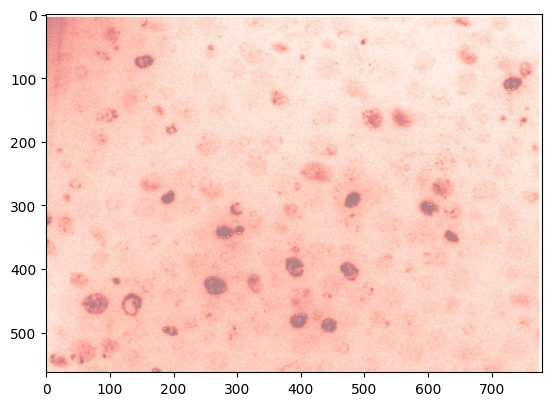

In [58]:
%%compare

# overlay images in different colors

plt.figure()
plt.imshow(fixed_image, cmap='Blues')

plt.figure()
plt.imshow(transformed_moving_image, cmap='Reds', alpha=0.5)

### Option 3: Use the `napari` viewer

napari is very convenient for visualizing registration results because images are shown in world coordinates.

In [64]:
import napari

def add_itk_image_to_viewer(viewer, image_itk, layer_name, colormap):
    viewer.add_image(
        image_itk,
        translate=fixed_image_itk.GetOrigin(),
        scale=fixed_image_itk.GetSpacing(),
        name=layer_name, colormap=colormap, blending='additive')

viewer = napari.Viewer()

add_itk_image_to_viewer(viewer, fixed_image_itk, 'fixed', 'Blue') 
add_itk_image_to_viewer(viewer, moving_image_itk, 'moving', 'Red') 
add_itk_image_to_viewer(viewer, transformed_moving_image, 'moving_transformed', 'Red') 

### Option 4: Load in Fiji

In [15]:
save_dir = '../example_data/registration_output'

import os
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

io.imsave(os.path.join(save_dir, 'transformed_moving_image.tif'), transformed_moving_image)

## Obtaining the resulting transformation

Similarly to how we provided a `registration_parameter_object`, we obtain the resulting transformation in a `transform_parameter_object`.
We can extract the transformation parameters from this object.

In [65]:
transform_parameter_map = result_transform_parameters.GetParameterMap(0)

pd.DataFrame(
    {'Parameter': transform_parameter_map.keys(),
    'Value': transform_parameter_map.values()}
    )

,Parameter,Value
0,CompressResultImage,"(false,)"
1,DefaultPixelValue,"(0,)"
2,Direction,"(1, 0, 0, 1)"
3,FinalBSplineInterpolationOrder,"(3,)"
4,FixedImageDimension,"(2,)"
5,FixedInternalImagePixelType,"(float,)"
6,HowToCombineTransforms,"(Compose,)"
7,Index,"(0, 0)"
8,InitialTransformParameterFileName,"(NoInitialTransform,)"
9,MovingImageDimension,"(2,)"


## Parameter interpretation

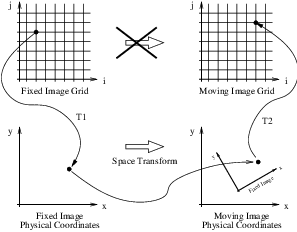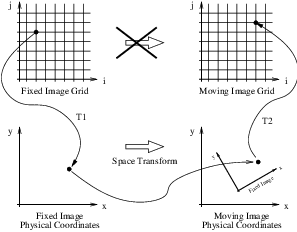

(illustration taken from https://www.orfeo-toolbox.org/SoftwareGuide/SoftwareGuidech9.html)

In [66]:
print('The obtained translational shift between the images (in physical units) is ',
      [float(v) for v in transform_parameter_map['TransformParameters']])

The obtained translational shift between the images (in physical units) is  [8.15587732988515, -12.874474293169026]


## Transform an image

Sometimes it's useful to apply the resulting transform parameters to an image independently of a registration run. Or to a different image.

In command line elastix, we'd use the `transformix` tool for this.

In [76]:
# apply the obtained transform parameters without previously performing registration again

result_image_transformix = itk.transformix_filter(
    moving_image,
    result_transform_parameters)


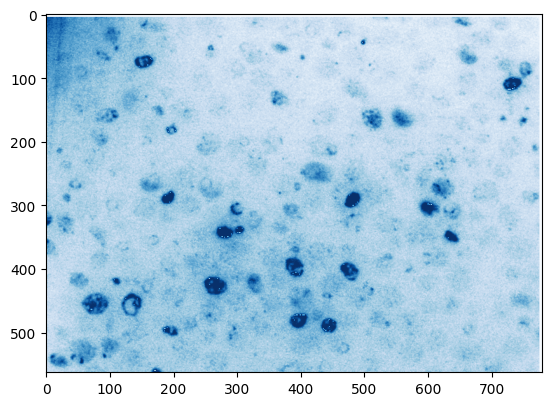
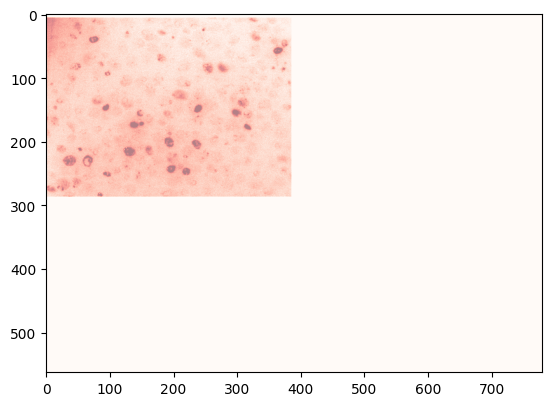

In [78]:
%%compare

plt.figure()
plt.imshow(transformed_moving_image, cmap='Blues')

plt.figure()
plt.imshow(result_image_transformix, cmap='Reds', alpha=0.5)

#### What went wrong? Shouldn't the two images above be the same?

The registration parameters are defined in physical space, so we need to use the itk image with the correct spacing and origin for performing the registration.

In [80]:
result_image_transformix = itk.transformix_filter(
    moving_image_itk, # notice the itk here
    result_transform_parameters)


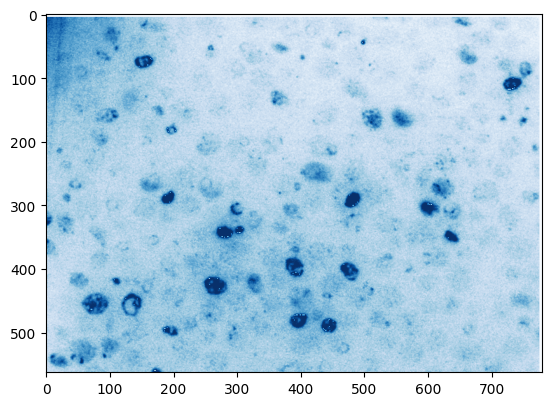
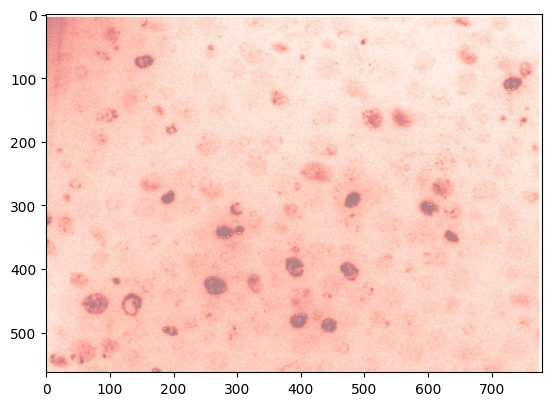

In [81]:
%%compare

plt.figure()
plt.imshow(transformed_moving_image, cmap='Blues')

plt.figure()
plt.imshow(result_image_transformix, cmap='Reds', alpha=0.5)